# Status of COVID-19 Cases in Ontario

URL: https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario

## Data Preparation

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

daily_change_url = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/8a88fe6d-d8fb-41a3-9d04-f0550a44999f/download/daily_change_in_cases_by_phu.csv'
#daily_change_url = 'data/covid19_ontario_daily.csv'
df = pd.read_csv(daily_change_url)

# Check last data point
print("Last data point on:", df.Date.max())

Last data point on: 2021-12-24


In [2]:
#df.columns

In [3]:
# Change date column to proper type and create another dataframe of dates to extract weekends
df.Date = pd.to_datetime(df.Date)
dfd = pd.DataFrame(df.Date)
dfd['day_of_week'] = dfd.Date.dt.day_of_week

# Monday = 0, weekend = 4,5,6
#dfd['is_wkend_holiday']=(dfd.day_of_week >= 4) * 1
dfd['is_wekend_holiday'] = 0   # ignore weekends

In [4]:
# extract holidays (2020, 2021)
import datetime
holidays = ['2020-01-01', '2020-02-17', '2020-04-10', '2020-05-18', '2020-07-01', '2020-09-07', '2020-10-12', '2020-12-25']
holidays.extend(['2021-01-01', '2021-02-15', '2021-04-02', '2021-05-24', '2021-07-01', '2021-09-06', '2021-10-11', '2021-12-25', '2021-12-26', '2021-12-27'])

# add halloweens and Valentines
holidays.extend(['2020-02-14', '2020-10-31', '2021-02-14', '2021-10-31'])
holidays = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in holidays]
for d in dfd.Date:
    if d in holidays:
        dfd.loc[dfd['Date']==d, "is_wkend_holiday"] = 1
        #print(dfd[dfd['Date']==d].is_wkend_holiday)
        
#dfd['is_wkend_holiday'] = dfd.is_wekend_holiday.fillna(0)
dfd.is_wkend_holiday = dfd.is_wkend_holiday.replace(np.nan, 0)

In [5]:
# check a holiday
dfd.loc[dfd.Date==datetime.datetime(2021,2,15)]
#dfd.loc[dfd.Date == datetime.datetime(2021,2,13)]


,Date,day_of_week,is_wekend_holiday,is_wkend_holiday
328,2021-02-15,0,0,1.0


In [6]:
# add columns for holiday+1 and holiday+5 days
holiday_add1 = (dfd.loc[dfd.is_wkend_holiday==1, "Date"] + datetime.timedelta(days=1)).tolist()
holiday_add5 = (dfd.loc[dfd.is_wkend_holiday==1, "Date"] + datetime.timedelta(days=5)).tolist()

dfd['holiday_add1'] = 0
dfd['holiday_add5'] = 0

for d in dfd.Date:
    if d in holiday_add1:
        dfd.loc[dfd['Date']==d, "holiday_add1"] = 1
    if d in holiday_add5:
        dfd.loc[dfd['Date']==d, "holiday_add5"] = 1

dfd.set_index('Date', inplace=True)

In [7]:
# Set df dataframe index to the date column
df.set_index('Date', inplace=True)

## Compute Moving Average

A moving average, aka a rolling or running average, is used to analyze the time-series data by calculating averages of different subsets of the complete dataset. It is also called a moving mean (MM) or rolling mean.

In [8]:
## Calculate 7-day SMA for the total positive COVID cases
df['Total_SMA_7'] = df.Total.rolling(window=7).mean()
df.tail()

,Algoma_District,Brant_County,Chatham_Kent,Durham_Region,Eastern_Ontario,Grey_Bruce,Haldimand_Norfolk,Haliburton_Kawartha_Pine_Ridge,Halton_Region,City_of_Hamilton,...,Southwestern,Sudbury_and_District,Thunder_Bay_District,Timiskaming,Toronto,Wellington_Dufferin_Guelph,Windsor_Essex_County,York_Region,Total,Total_SMA_7
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-20,17.0,34.0,33.0,142.0,42.0,46.0,33.0,29.0,240.0,181.0,...,35.0,31.0,6.0,0.0,1056.0,62.0,96.0,310.0,3784,2863.428571
2021-12-21,10.0,24.0,8.0,160.0,27.0,15.0,13.0,18.0,245.0,158.0,...,34.0,11.0,4.0,3.0,901.0,66.0,65.0,345.0,3453,3152.571429
2021-12-22,14.0,23.0,7.0,238.0,24.0,40.0,17.0,26.0,223.0,149.0,...,27.0,53.0,10.0,6.0,1284.0,77.0,68.0,479.0,4383,3520.428571
2021-12-23,36.0,25.0,27.0,334.0,95.0,64.0,28.0,57.0,259.0,277.0,...,65.0,36.0,22.0,13.0,1527.0,112.0,103.0,470.0,5790,4001.714286
2021-12-24,29.0,81.0,47.0,349.0,156.0,57.0,70.0,60.0,745.0,487.0,...,133.0,64.0,33.0,15.0,2456.0,221.0,163.0,604.0,9571,4922.714286


## Archive the Dataset

In [9]:
# save a copy (uncomment the following statement)
df.to_csv('data/covid19_ontario_daily.csv')

<AxesSubplot:xlabel='Date'>

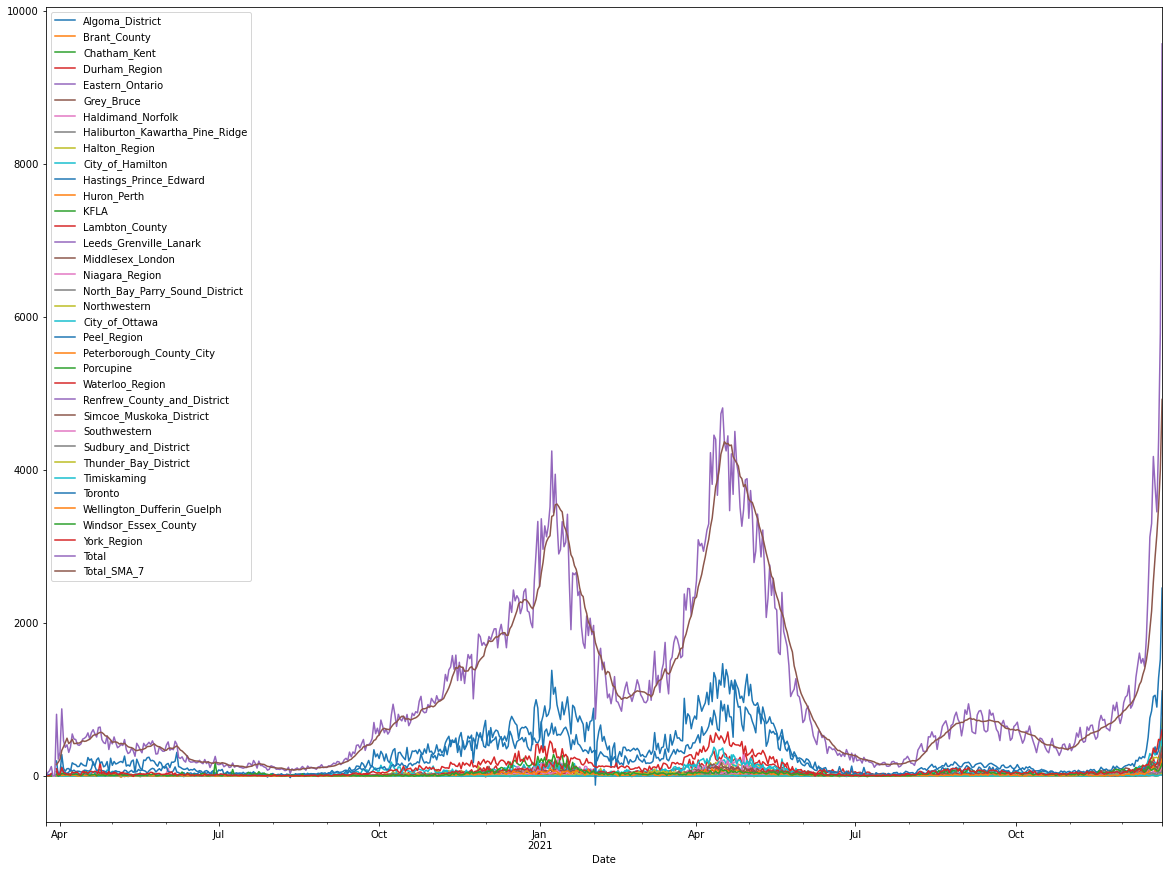

In [10]:
plt.rcParams['figure.figsize']=(20,15)
df.plot()
#plt.show()

In [11]:
# Check correlations

print("Torono-York:", df.Toronto.corr(df.York_Region))
print("Peel-Algoma:", df.Peel_Region.corr(df.Algoma_District))
print("Ottawa-holidays:", df.City_of_Ottawa.corr(dfd.is_wkend_holiday))
print("Toronto-holidays+5:", df.Toronto.corr(dfd.holiday_add5))

Torono-York: 0.9391433353101046
Peel-Algoma: 0.011846628280273561
Ottawa-holidays: -0.009144682685436377
Toronto-holidays+5: 0.019467164336080322


<AxesSubplot:xlabel='Date'>

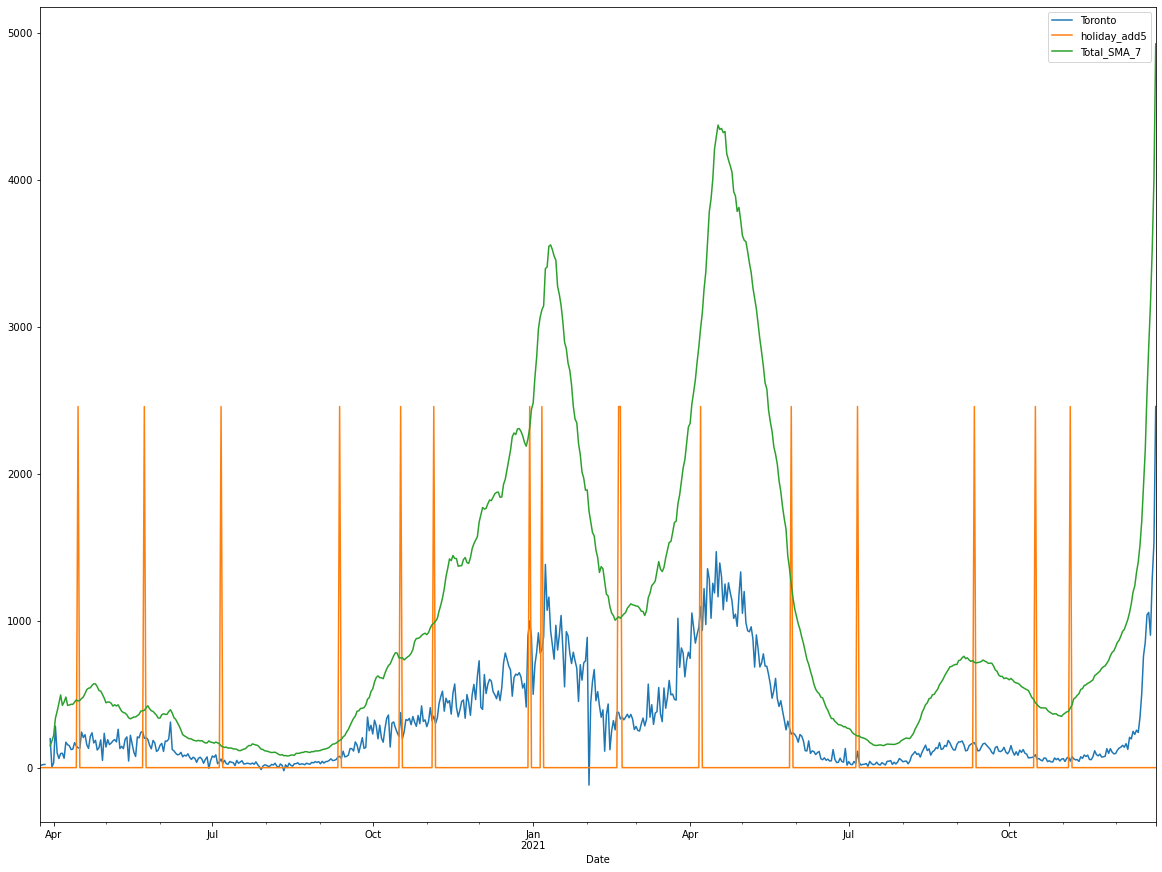

In [12]:
# Visual check on effect of holidays (+5 days)
df1 = df.join(dfd)[['Toronto','holiday_add5', 'Total_SMA_7']]
df1.holiday_add5 *= df1.Toronto.max()   # normalize holidays to Toronto scale
df1.plot()

## Check on the latest stats:

In [13]:
df[df.index==pd.to_datetime(datetime.datetime.now().date())]

,Algoma_District,Brant_County,Chatham_Kent,Durham_Region,Eastern_Ontario,Grey_Bruce,Haldimand_Norfolk,Haliburton_Kawartha_Pine_Ridge,Halton_Region,City_of_Hamilton,...,Southwestern,Sudbury_and_District,Thunder_Bay_District,Timiskaming,Toronto,Wellington_Dufferin_Guelph,Windsor_Essex_County,York_Region,Total,Total_SMA_7
Date,,,,,,,,,,,,,,,,,,,,,


<AxesSubplot:title={'center':'York Region Covid-19 Cases since Nov 1, 2021'}, xlabel='Date'>

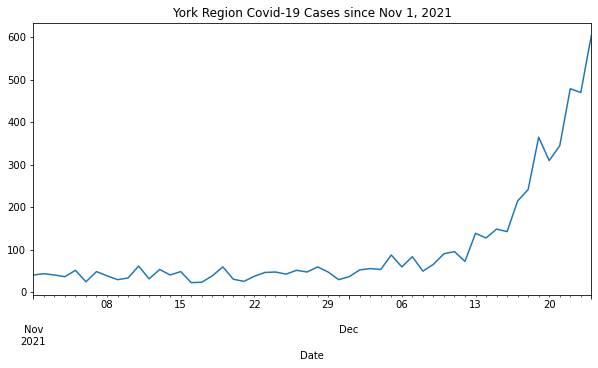

In [14]:
df.York_Region[df.index > pd.to_datetime('2021-10-31')].plot(figsize=(10,5), title='York Region Covid-19 Cases since Nov 1, 2021')

### Plot York with a couple of moving averages

Plot with SMA and EMA

In [15]:
dfy = pd.DataFrame(df.York_Region[df.index >= pd.to_datetime('2021-01-01')])
dfy.describe()

,York_Region
count,358.000000
mean,127.829609
std,132.292336
min,0.000000
25%,32.000000
50%,74.000000
75%,172.750000
max,604.000000


In [16]:
dfy['SMA_7']=dfy.York_Region.rolling(window=7).mean()
dfy['EMA']=dfy.York_Region.ewm(span=40, adjust=False).mean()
dfy

,York_Region,SMA_7,EMA
Date,,,
2021-01-01,300.0,NaN,300.000000
2021-01-02,395.0,NaN,304.634146
2021-01-03,308.0,NaN,304.798334
2021-01-04,389.0,NaN,308.905733
2021-01-05,213.0,NaN,304.227404
...,...,...,...
2021-12-20,310.0,221.714286,108.565557
2021-12-21,345.0,252.714286,120.098945
2021-12-22,479.0,299.857143,137.606313


<AxesSubplot:xlabel='Date'>

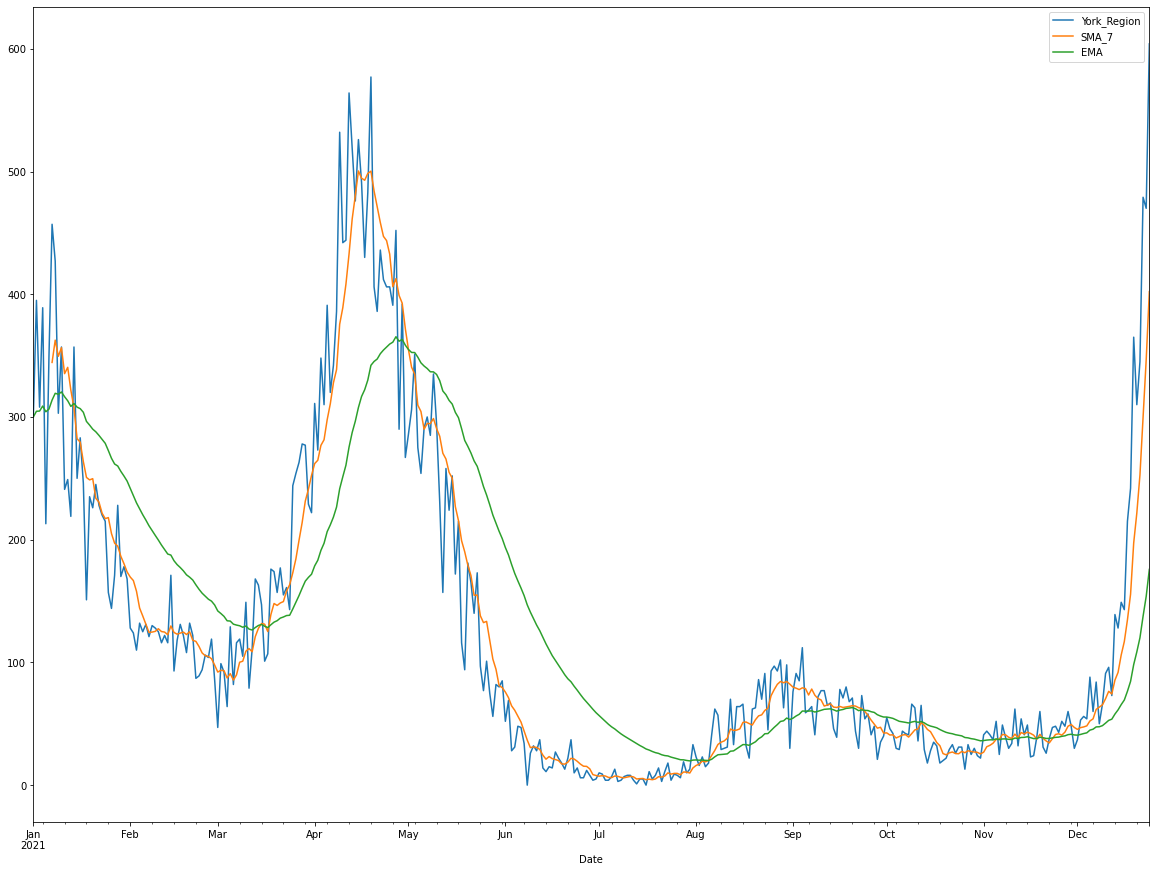

In [17]:
dfy.plot()

## Last 10 Days in Select Regions

In [18]:
df[df.index > pd.to_datetime(datetime.datetime.now().date() - datetime.timedelta(days=10))][['KFLA','Middlesex_London','York_Region','Toronto','Total']]

,KFLA,Middlesex_London,York_Region,Toronto,Total
Date,,,,,
2021-12-18,144.0,126.0,242.0,851.0,3301
2021-12-19,129.0,136.0,365.0,1039.0,4177
2021-12-20,130.0,123.0,310.0,1056.0,3784
2021-12-21,118.0,110.0,345.0,901.0,3453
2021-12-22,103.0,111.0,479.0,1284.0,4383
2021-12-23,146.0,253.0,470.0,1527.0,5790
2021-12-24,195.0,379.0,604.0,2456.0,9571


## Covid Hospitalization Stats
URL: https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv

In [19]:
hosp_url = "https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv"
dfh = pd.read_csv(hosp_url)

# Check last data point
print("Last data point on:", dfh.date.max())

Last data point on: 2021-12-24


In [20]:
# reindex the data frame by date
dfh.date = pd.to_datetime(dfh.date)
dfh.set_index("date", inplace=True)
# dfh.drop(['date'], axis=1, inplace=True)

In [21]:
# Archive the data set (uncomment the following statement)
dfh.to_csv('data/covid19_ontario_hosp_icu.csv')

In [22]:
# data set comprises of distinct regions
dfh.oh_region.unique()

array(['CENTRAL', 'EAST', 'NORTH', 'TORONTO', 'WEST'], dtype=object)

<AxesSubplot:xlabel='date'>

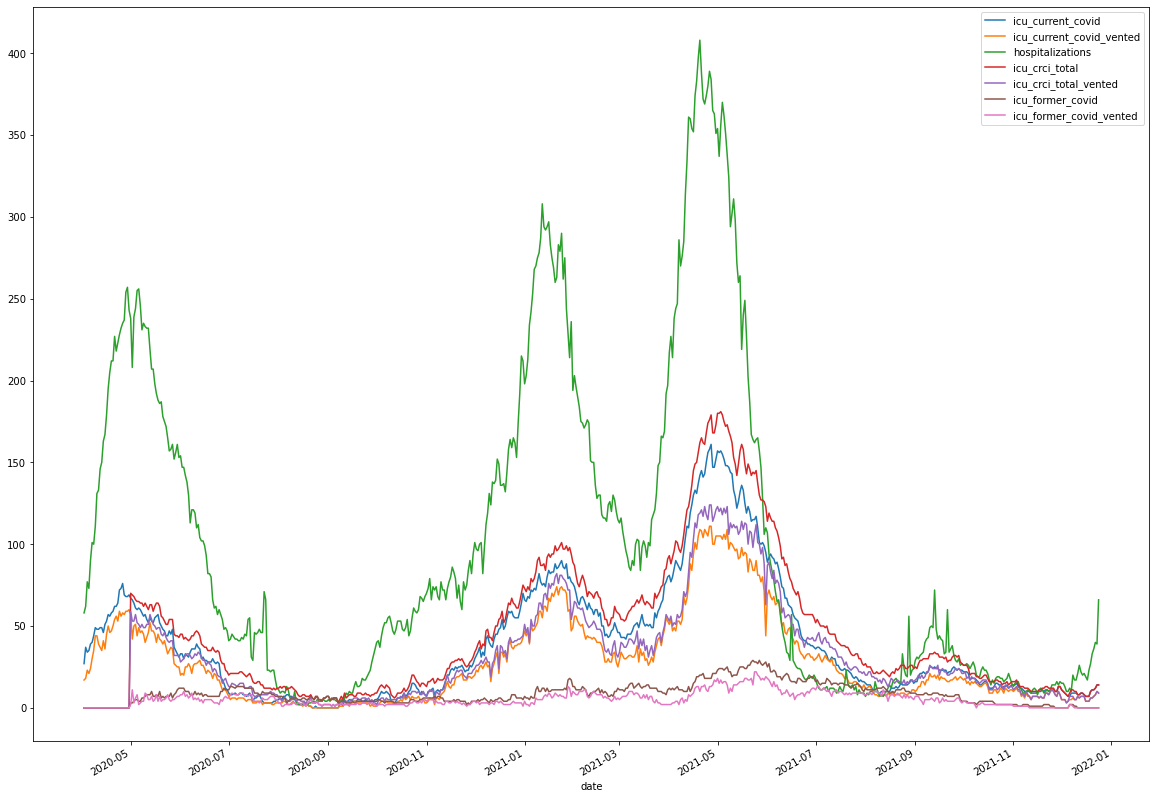

In [23]:
# Plot the Toronto regions
dfh[dfh.oh_region == 'TORONTO'].plot()

In [24]:
# Aggregate data across the regions
# regions = ['CENTRAL', 'EAST', 'NORTH', 'TORONTO', 'WEST']
# dfh_total = dfh[dfh.oh_region == 'CENTRAL'] + dfh[dfh.oh_region == 'EAST'] + dfh[dfh.oh_region == 'NORTH'] + dfh[dfh.oh_region == 'TORONTO'] + dfh[dfh.oh_region == 'WEST']

regions = dfh.oh_region.unique()
dfh_total = dfh[dfh.oh_region == regions[0]]
for i in range(1, len(regions)):
    dfh_total += dfh[dfh.oh_region == regions[i]]
dfh_total.tail()

,oh_region,icu_current_covid,icu_current_covid_vented,hospitalizations,icu_crci_total,icu_crci_total_vented,icu_former_covid,icu_former_covid_vented
date,,,,,,,,
2021-12-20,CENTRALEASTNORTHTORONTOWEST,152,104,385,164,109,12,5
2021-12-21,CENTRALEASTNORTHTORONTOWEST,153,101,413,165,105,12,4
2021-12-22,CENTRALEASTNORTHTORONTOWEST,155,103,420,168,108,13,5
2021-12-23,CENTRALEASTNORTHTORONTOWEST,156,101,440,169,106,13,5
2021-12-24,CENTRALEASTNORTHTORONTOWEST,154,97,508,164,102,10,5


In [25]:
# check a data instance
icu1 = dfh[dfh.index == pd.to_datetime('2021-12-01')].icu_current_covid.sum()
icu2 = dfh_total[dfh_total.index == pd.to_datetime('2021-12-01')].icu_current_covid[0]
print("sum of regions({0}) == result column({1}) is {2}".format(icu1, icu2, icu1==icu2))

sum of regions(139) == result column(139) is True


<AxesSubplot:xlabel='date'>

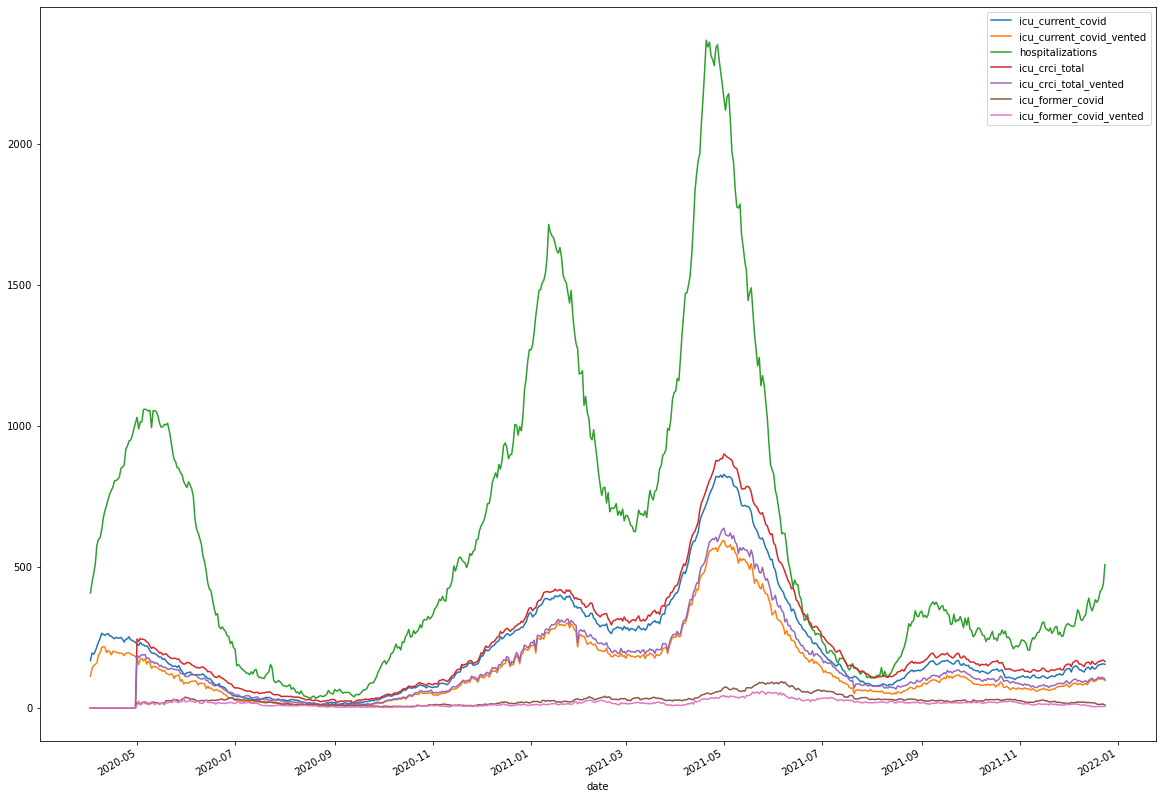

In [26]:
dfh_total.plot()